In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Fri Jan 26 17:07:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_quantize500/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

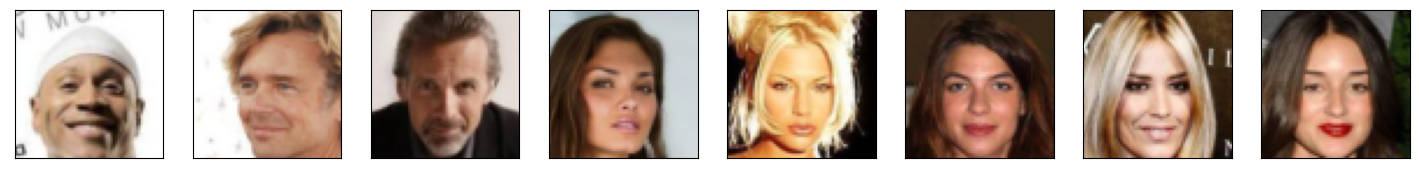

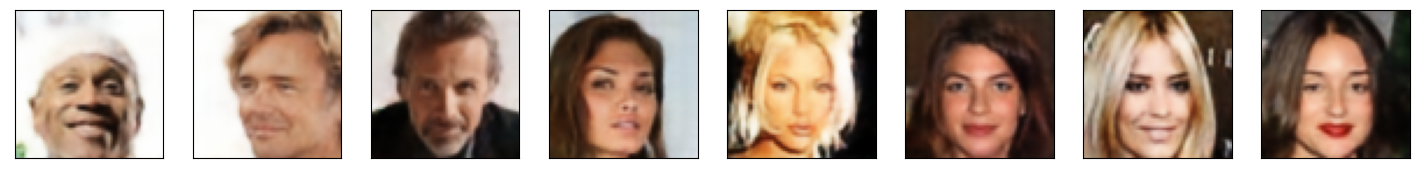

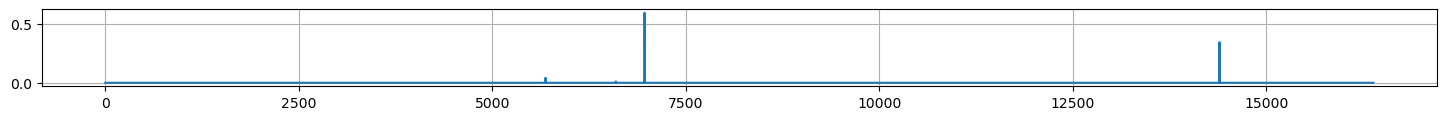

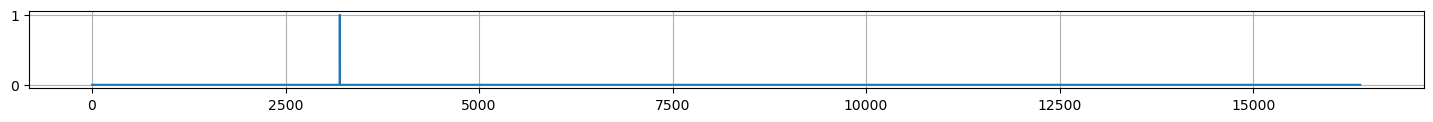

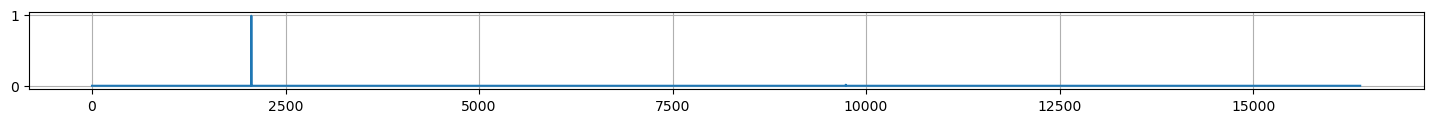

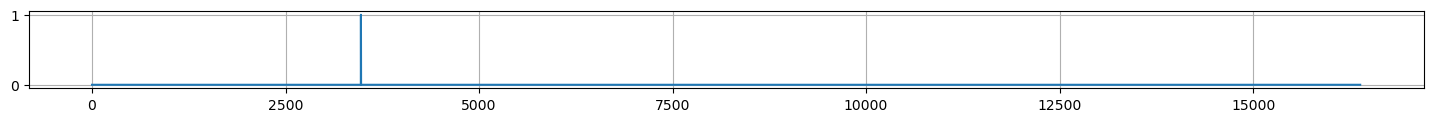

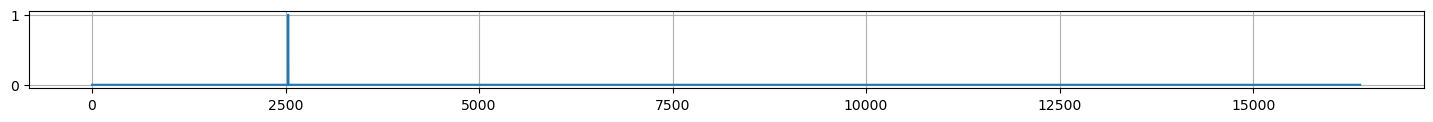

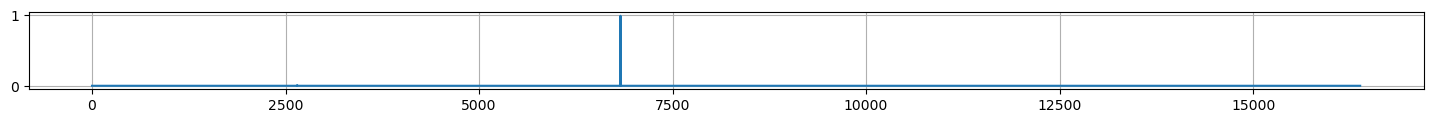

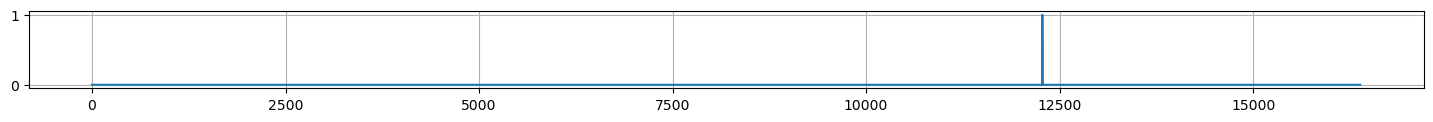

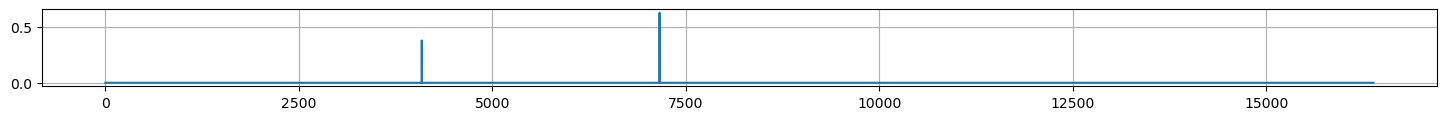

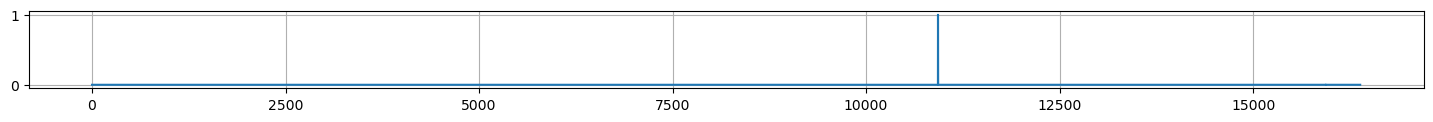

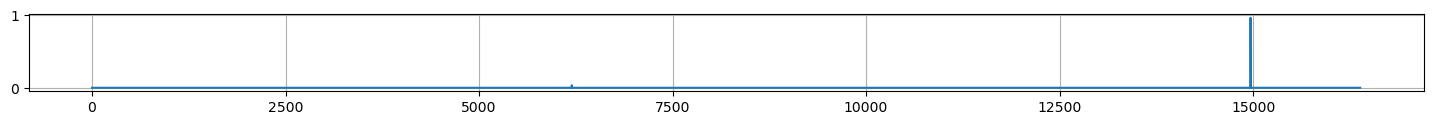

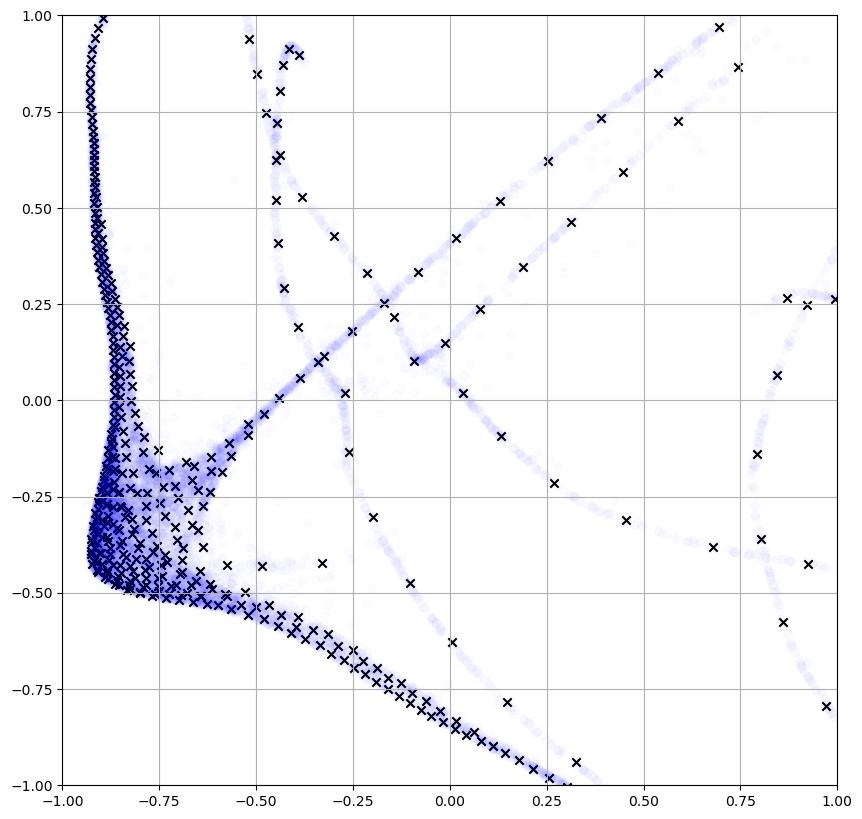

2001
lse_loss -401.5564270019531
commit_loss 7.249631016748026e-05
recon_loss 0.0007457956671714783
2002
lse_loss -401.160888671875
commit_loss 7.075682515278459e-05
recon_loss 0.0006792800850234926
2003
lse_loss -407.75982666015625
commit_loss 7.632167398696765e-05
recon_loss 0.0007669659098610282
2004
lse_loss -397.2504577636719
commit_loss 7.119274232536554e-05
recon_loss 0.0007881814963184297
2005
lse_loss -403.5085144042969
commit_loss 7.590583845740184e-05
recon_loss 0.0007678500260226429
2006
lse_loss -406.37530517578125
commit_loss 8.106020686682314e-05
recon_loss 0.0008011962636373937
2007
lse_loss -412.21588134765625
commit_loss 7.910524436738342e-05
recon_loss 0.0007408778183162212
2008
lse_loss -408.2577209472656
commit_loss 7.921931683085859e-05
recon_loss 0.000718161347322166
2009
lse_loss -409.94635009765625
commit_loss 7.57255038479343e-05
recon_loss 0.0007038790499791503
2010
lse_loss -400.73321533203125
commit_loss 7.561986421933398e-05
recon_loss 0.000738326460123062

lse_loss -402.7578125
commit_loss 7.534820178989321e-05
recon_loss 0.0008207954233512282
2085
lse_loss -404.2418518066406
commit_loss 7.180240208981559e-05
recon_loss 0.0007529838476330042
2086
lse_loss -407.6655578613281
commit_loss 7.136856584111229e-05
recon_loss 0.0007393364794552326
2087
lse_loss -408.5663757324219
commit_loss 7.21419564797543e-05
recon_loss 0.0007630779291503131
2088
lse_loss -413.3182067871094
commit_loss 7.130169251468033e-05
recon_loss 0.0007423344068229198
2089
lse_loss -412.3147277832031
commit_loss 7.312178058782592e-05
recon_loss 0.0007300684228539467
2090
lse_loss -406.8426513671875
commit_loss 7.090487633831799e-05
recon_loss 0.000776878499891609
2091
lse_loss -404.0898742675781
commit_loss 7.205817382782698e-05
recon_loss 0.0006752423942089081
2092
lse_loss -412.0952453613281
commit_loss 7.38276430638507e-05
recon_loss 0.0006515198620036244
2093
lse_loss -404.4670715332031
commit_loss 7.163459667935967e-05
recon_loss 0.0008086145389825106
2094
lse_loss 

2167
lse_loss -410.3407897949219
commit_loss 7.323820318561047e-05
recon_loss 0.0008199006551876664
2168
lse_loss -401.0987548828125
commit_loss 7.70612241467461e-05
recon_loss 0.0008153440430760384
2169
lse_loss -408.1253662109375
commit_loss 7.22139811841771e-05
recon_loss 0.0007362618925981224
2170
lse_loss -397.6455078125
commit_loss 7.473213190678507e-05
recon_loss 0.000713909394107759
2171
lse_loss -410.0105285644531
commit_loss 7.184276182670146e-05
recon_loss 0.0007582636317238212
2172
lse_loss -405.54168701171875
commit_loss 7.49915634514764e-05
recon_loss 0.0007298652781173587
2173
lse_loss -396.020751953125
commit_loss 7.560631638625637e-05
recon_loss 0.0007894992595538497
2174
lse_loss -405.9893493652344
commit_loss 7.608438318129629e-05
recon_loss 0.0008255575085058808
2175
lse_loss -404.4342041015625
commit_loss 7.21953110769391e-05
recon_loss 0.0007325224578380585
2176
lse_loss -409.6260070800781
commit_loss 7.54884968046099e-05
recon_loss 0.0009257371420972049
2177
lse_

lse_loss -400.8443298339844
commit_loss 7.251569331856444e-05
recon_loss 0.0008204185869544744
2252
lse_loss -401.7525329589844
commit_loss 7.675275264773518e-05
recon_loss 0.0008134719682857394
2253
lse_loss -403.95941162109375
commit_loss 7.31553154764697e-05
recon_loss 0.000725120771676302
2254
lse_loss -407.87841796875
commit_loss 7.301237201318145e-05
recon_loss 0.0008121005957946181
2255
lse_loss -411.139404296875
commit_loss 7.770016964059323e-05
recon_loss 0.0008715339354239404
2256
lse_loss -403.2502746582031
commit_loss 7.222875137813389e-05
recon_loss 0.0007436882588081062
2257
lse_loss -405.40618896484375
commit_loss 7.443704816978425e-05
recon_loss 0.0008747867541387677
2258
lse_loss -395.3706970214844
commit_loss 7.565580017399043e-05
recon_loss 0.0008799635688774288
2259
lse_loss -414.5396728515625
commit_loss 7.451076089637354e-05
recon_loss 0.0008337089093402028
2260
lse_loss -409.81298828125
commit_loss 7.732579979347065e-05
recon_loss 0.0007770713418722153
2261
lse_l

2336
lse_loss -400.3027648925781
commit_loss 7.16095746611245e-05
recon_loss 0.000747396145015955
2337
lse_loss -407.93017578125
commit_loss 7.450475823134184e-05
recon_loss 0.0007355646230280399
2338
lse_loss -407.9771728515625
commit_loss 7.553283649031073e-05
recon_loss 0.0006817523390054703
2339
lse_loss -395.9138488769531
commit_loss 7.359616574831307e-05
recon_loss 0.0008047566516324878
2340
lse_loss -402.96392822265625
commit_loss 7.534351607318968e-05
recon_loss 0.0007656707894057035
2341
lse_loss -400.6937561035156
commit_loss 7.218158862087876e-05
recon_loss 0.0007231291383504868
2342
lse_loss -400.3791809082031
commit_loss 7.597899093525484e-05
recon_loss 0.00082674331497401
2343
lse_loss -407.039794921875
commit_loss 7.117490167729557e-05
recon_loss 0.0007348285871557891
2344
lse_loss -402.4302978515625
commit_loss 7.254922820720822e-05
recon_loss 0.000756626483052969
2345
lse_loss -409.29986572265625
commit_loss 7.279928831849247e-05
recon_loss 0.0007620030082762241
2346
l

lse_loss -406.6653137207031
commit_loss 7.00876335031353e-05
recon_loss 0.0006962780607864261
2420
lse_loss -399.53564453125
commit_loss 7.568749424535781e-05
recon_loss 0.0009858387056738138
2421
lse_loss -407.1801452636719
commit_loss 7.004942744970322e-05
recon_loss 0.0008581198053434491
2422
lse_loss -407.3036804199219
commit_loss 7.045889651635662e-05
recon_loss 0.0008484073914587498
2423
lse_loss -404.2953186035156
commit_loss 7.574565097456798e-05
recon_loss 0.0008154101669788361
2424
lse_loss -411.5802307128906
commit_loss 7.054516754578799e-05
recon_loss 0.0006711657624691725
2425
lse_loss -411.2929382324219
commit_loss 7.437872409354895e-05
recon_loss 0.0007799051236361265
2426
lse_loss -412.1336669921875
commit_loss 7.46873120078817e-05
recon_loss 0.000761038507334888
2427
lse_loss -402.6825256347656
commit_loss 7.762429595459253e-05
recon_loss 0.0008242063922807574
2428
lse_loss -410.46392822265625
commit_loss 7.369494414888322e-05
recon_loss 0.0007332723471336067
2429
lse_

2504
lse_loss -406.202880859375
commit_loss 7.329606160055846e-05
recon_loss 0.0007978504872880876
2505
lse_loss -400.4078369140625
commit_loss 6.92108878865838e-05
recon_loss 0.0007422915659844875
2506
lse_loss -406.71710205078125
commit_loss 7.161370012909174e-05
recon_loss 0.0008293503778986633
2507
lse_loss -411.1795349121094
commit_loss 7.236848614411429e-05
recon_loss 0.0007245085434988141
2508
lse_loss -410.1917724609375
commit_loss 7.41708354325965e-05
recon_loss 0.0007613002671860158
2509
lse_loss -404.781982421875
commit_loss 7.262567669386044e-05
recon_loss 0.0006840485148131847
2510
lse_loss -401.9189758300781
commit_loss 7.678380643483251e-05
recon_loss 0.0007986471755430102
2511
lse_loss -407.3569030761719
commit_loss 8.045043796300888e-05
recon_loss 0.0007710367208346725
2512
lse_loss -404.6850891113281
commit_loss 7.849045505281538e-05
recon_loss 0.0008488769526593387
2513
lse_loss -402.9134826660156
commit_loss 7.520411600125954e-05
recon_loss 0.0008358657360076904
251

2589
lse_loss -394.5760192871094
commit_loss 7.929773710202426e-05
recon_loss 0.0008281447226181626
2590
lse_loss -409.8080139160156
commit_loss 7.24452402209863e-05
recon_loss 0.0008026803843677044
2591
lse_loss -407.04254150390625
commit_loss 7.100233779055998e-05
recon_loss 0.0007471700082533062
2592
lse_loss -406.19024658203125
commit_loss 6.981594196986407e-05
recon_loss 0.0007838341407477856
2593
lse_loss -409.3246154785156
commit_loss 7.338878640439361e-05
recon_loss 0.0007767760544084013
2594
lse_loss -409.3328857421875
commit_loss 7.498406193917617e-05
recon_loss 0.0007906360551714897
2595
lse_loss -403.35113525390625
commit_loss 7.815203571226448e-05
recon_loss 0.0009352703345939517
2596
lse_loss -408.425048828125
commit_loss 6.9408692070283e-05
recon_loss 0.0007350710220634937
2597
lse_loss -404.8479919433594
commit_loss 7.270698552019894e-05
recon_loss 0.0007425236399285495
2598
lse_loss -408.5193786621094
commit_loss 7.437414024025202e-05
recon_loss 0.0008616851991973817
2

lse_loss -399.5011901855469
commit_loss 7.759744039503857e-05
recon_loss 0.0008286313968710601
2674
lse_loss -412.1934509277344
commit_loss 7.665094744879752e-05
recon_loss 0.0008145958418026567
2675
lse_loss -409.61932373046875
commit_loss 7.559852383565158e-05
recon_loss 0.0007504662498831749
2676
lse_loss -407.62518310546875
commit_loss 7.699824345763773e-05
recon_loss 0.0006953658885322511
2677
lse_loss -404.7677001953125
commit_loss 7.910936255939305e-05
recon_loss 0.0008665370987728238
2678
lse_loss -403.5439758300781
commit_loss 7.813603588147089e-05
recon_loss 0.0007765046320855618
2679
lse_loss -408.4735107421875
commit_loss 7.195357466116548e-05
recon_loss 0.0008361732470802963
2680
lse_loss -406.9127502441406
commit_loss 7.463456131517887e-05
recon_loss 0.0008019269444048405
2681
lse_loss -406.4734191894531
commit_loss 7.40940886316821e-05
recon_loss 0.0008317145984619856
2682
lse_loss -402.200927734375
commit_loss 7.432814163621515e-05
recon_loss 0.0008695998694747686
2683


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 500*1000)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 